Compare the magnitudes produced by tractor to the magnitudes produced by the curve of growth

In [1]:
%matplotlib inline
from glob import glob
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
import os
import matplotlib
from itertools import combinations

In [2]:
data_path = '/Users/matt/Data/legacydata/sv3-clustering/raw_output/'
figure_path = '/Users/matt/Data/Figures/legacyhalos/residuals/2023-05-19/'
if not os.path.isdir(figure_path):
    os.makedirs(figure_path)
ellipse_nm = 'total_ellipse.fits'
tractor_nm = 'total_tractor.fits'
sample_nm = 'total_sample.fits'

In [3]:
mag_bins = np.array([12.06, 12.804, 13.548, 14.292, 15.036, 15.78, 16.524, 17.268, 18.012, 18.756, 19.49992683], dtype=np.float64)

def flux_to_mag(flux):
    return (-5/2)*np.log10(flux) + 22.5

def mag_to_flux(mag):
    return 10**((2/5)* (22.5 - mag))

flux_bins = mag_to_flux(mag_bins)

In [4]:
tractor = Table.read(data_path+tractor_nm)
ellipse = Table.read(data_path+ellipse_nm)
sample = Table.read(data_path+sample_nm)
print(len(tractor))

1764


In [5]:
invalid_ids = [39627782266819092, 39627764248087271, 39627788436636438, 39628433268934789, 39627775652400602, 
               39627841624608915, 39627799828368481, 39627800377820319, 39628411747961568, 39627769595823325, 
               39627860868073046, 39628427900228087, 39627770187224570, 39627890911872391, 39627908976739460, 
               39628433260544510, 39627841578468374]
mask = np.isin(tractor['ref_id'], invalid_ids, invert=True)
tractor = tractor[mask]
sample = sample[mask]
ellipse = ellipse[mask]
print(len(tractor))

1747


In [6]:
shape_r_cut = tractor['shape_r'] >= 1
tractor = tractor[shape_r_cut]
sample = sample[shape_r_cut]
ellipse = ellipse[shape_r_cut]  
print(len(tractor))

1400


In [7]:
root_url = 'https://portal.nersc.gov/project/cosmo/temp/mkwiecien/sv3-html/3962/{0}/{1}.html'

# ids = sample[np.abs(delta_mag_r) > 2]['TARGETID']
# ids = sample[z > 0.52]['TARGETID']
ids = sample[ellipse['COG_SMA50_R'] > 900]['TARGETID']

for id in ids:
    print(root_url.format(id, id))

invalid_ids = [x for x in ids if x != '39628362649439929']
print(invalid_ids)

https://portal.nersc.gov/project/cosmo/temp/mkwiecien/sv3-html/3962/39627811954098481/39627811954098481.html
[39627811954098481]


In [7]:
print(np.all(tractor['ref_id'] == ellipse['ID_CENT']))
print(np.all(tractor['ref_id'] == sample['TARGETID']))

True
True


In [8]:
def get_mags(cat, bands=["g", "r", "z"], pipeline=False, cog=False):
    res = []
    for band in bands:
        mag = None
        ff = 0
        if pipeline:
            iv = cat["flux_ivar_{}".format(band).lower()]
            ff = cat["flux_{}".format(band).lower()]
        elif cog:
            mag = cat["cog_mtot_{}".format(band).upper()]

        if mag:
            res.append("{:.3f}".format(mag))
        else:
            if ff > 0:
                mag = 22.5 - 2.5 * np.log10(ff)
                if iv > 0:
                    ee = 1 / np.sqrt(iv)
                    magerr = 2.5 * ee / ff / np.log(10)
                res.append("{:.3f}".format(mag))
            elif ff < 0 and iv > 0:
                # upper limit
                mag = 22.5 - 2.5 * np.log10(1 / np.sqrt(iv))
                res.append(">{:.3f}".format(mag))
            else:
                res.append('0')
    return res

In [9]:
grz_trac = [get_mags(t, pipeline=True) for t in tractor]
grz_trac = np.array(list(zip(*grz_trac)), dtype=np.float64)

grz_cog = np.array([get_mags(e, cog=True) for e in ellipse], dtype=np.float64)
grz_cog = np.array(list(zip(*grz_cog)), dtype=np.float64)


r_mag = flux_to_mag(sample['FLUX_R_DERED'])
r_flux = sample['FLUX_R_DERED']
z = sample['Z']
ra = sample['RA']
dec = sample['DEC']
r_mosaic = sample['RADIUS_MOSAIC']
ref_id = sample['TARGETID']

tractor_mag_r = grz_trac[1]
delta_mag_r_tractor = grz_cog[1] - grz_trac[1]
# delta_mag_r = grz_cog[1] - r_mag

In [30]:
def plot_data_and_sem(ax1, ax2, delta_mag_r, x_values, x_bins):
    # Simple scatter plot of all values
    ax1.scatter(x_values, delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='tab:blue')
    ax1.hlines(0, -10000000, 10000000, ls='dashed', color='k')
    ax1.vlines(x_bins, -20000, 20000, ls='dashed', color='k')
    ax1.set_ylabel(r'mag-$r_{LH}$ - mag-$r_{LP}$', fontsize=20)
    ax1.set_ylim(-5,5)
    # Calculate the stats in the bins
    mean = []
    std = []
    mid_pt = []
    binned_sample = []
    stdem = []
    for i in range(len(x_bins)-1):
        this_bin_low = x_values > x_bins[i]
        this_bin_max = x_values <= x_bins[i+1]
        
        mask = np.all([this_bin_low.flatten(), this_bin_max.flatten()], axis=0)
        this_bin = delta_mag_r[mask]
        
        binned_sample.append(this_bin)
        mean.append(np.mean(this_bin))
        std.append(np.std(this_bin))
        stdem.append(sem(this_bin))
        mid_pt.append((x_bins[i+1]+  x_bins[i])/2)

    # Plot the mean/stdem
    ax2.violinplot(binned_sample, mid_pt, points=100, widths=0.5, 
                   bw_method=0.5, showmeans=True, showextrema=True, showmedians=True)
    # ax2.errorbar(mid_pt, mean, stdem, marker='o', lw=1, c='k', linestyle='none', 
    #     capsize=2, markeredgecolor='k', markerfacecolor='none', ecolor='k')
    ax2.hlines(0, -10000000, 10000000, ls='dashed', color='k')
    ax2.vlines(x_bins, -20000, 20000, ls='dashed', color='k')
    ax2.set_ylabel(r'mag-$r_{LH}$ - mag-$r_{LP}$', fontsize=20)
    ax2.set_ylim(-1.5,1)

    for i in range(len(binned_sample)):
        n = len(binned_sample[i])
        mid_pt[i]
        ax2.annotate(f'N={n}', xy=(mid_pt[i], .65), xycoords='data', horizontalalignment='center', fontsize=10)

https://www.legacysurvey.org/dr10/catalogs/

In [31]:
# tractor_columns = ['sersic', 'shape_r', 'fracmasked_r']
tractor_columns = tractor.colnames
invalid_cols = ['release', 'brickid', 'brickname', 'brick_primary', 'type', 'dchisq', 'ref_cat', 'pmra', 
                'pmdec', 'parallax', 'pmra_ivar', 'pmdec_ivar', 'parallax_ivar', 'ref_epoch', 
                'gaia_phot_g_mean_mag', 'gaia_phot_g_mean_flux_over_error', 'gaia_phot_g_n_obs', 
                'gaia_phot_bp_mean_mag', 'gaia_phot_bp_mean_flux_over_error', 'gaia_phot_bp_n_obs', 
                'gaia_phot_rp_mean_mag', 'gaia_phot_rp_mean_flux_over_error', 'gaia_phot_rp_n_obs', 
                'gaia_phot_variable_flag', 'gaia_astrometric_excess_noise', 'gaia_astrometric_excess_noise_sig', 
                'gaia_astrometric_n_obs_al', 'gaia_astrometric_n_good_obs_al', 'gaia_astrometric_weight_al', 
                'gaia_duplicated_source', 'gaia_a_g_val', 'gaia_e_bp_min_rp_val', 'gaia_phot_bp_rp_excess_factor', 
                'gaia_astrometric_sigma5d_max', 'gaia_astrometric_params_solved', 'apflux_g', 'apflux_r', 
                'apflux_z', 'apflux_resid_g', 'apflux_resid_r', 'apflux_resid_z', 'apflux_blobresid_g', 
                'apflux_blobresid_r', 'apflux_blobresid_z', 'apflux_ivar_g', 'apflux_ivar_r', 'apflux_ivar_z', 
                'apflux_masked_g', 'apflux_masked_r', 'apflux_masked_z', 'nobs_g', 'nobs_r', 'nobs_z', 'ngood_g', 
                'anymask_g', 'anymask_r', 'allmask_g', 'allmask_r', 'allmask_z', 'anymask_z', 'ngood_z', 'ngood_r', 
                'ref_id', 'ra', 'dec', 'fitbits', 'maskbits', 'objid']

tractor_columns = [x for x in tractor_columns if x not in invalid_cols]


log_scale_columns = [
    'shape_e2_ivar', 'shape_e1_ivar', 'shape_r_ivar', 'sersic_ivar',
    'blob_nea_z', 'blob_nea_r', 'blob_nea_g', 'nea_z', 'nea_r', 'nea_g',
    'fracin_z', 'fracin_r', 'fracin_g', 'fracmasked_z', 'fracmasked_r',
    'fracmasked_g', 'fracflux_z', 'fracflux_r', 'fracflux_g',
    'rchisq_r', 'rchisq_g', 'rchisq_z', 'fibertotflux_z', 'fibertotflux_r', 
    'fibertotflux_g','fiberflux_z', 'fiberflux_r', 'fiberflux_g',
    'flux_z', 'flux_r', 'flux_g', 'by', 'bx', 'dec_ivar', 'ra_ivar'
]


In [32]:
ellipse_cols = ['sma_moment', 'pa_moment', 'eps_moment', 'cog_sma50_r']

In [33]:
ee = np.hypot(tractor["shape_e1"], tractor["shape_e2"])
ba = (1 - ee) / (1 + ee)
pa = 180 - (
    -np.rad2deg(np.arctan2(tractor["shape_e2"], tractor["shape_e1"]) / 2)
)
pa = pa % 180
e = 1-ba


### Looking at residuals as a function of redshift and magnitude, in a 2d plane

(-3.0, 1.0)

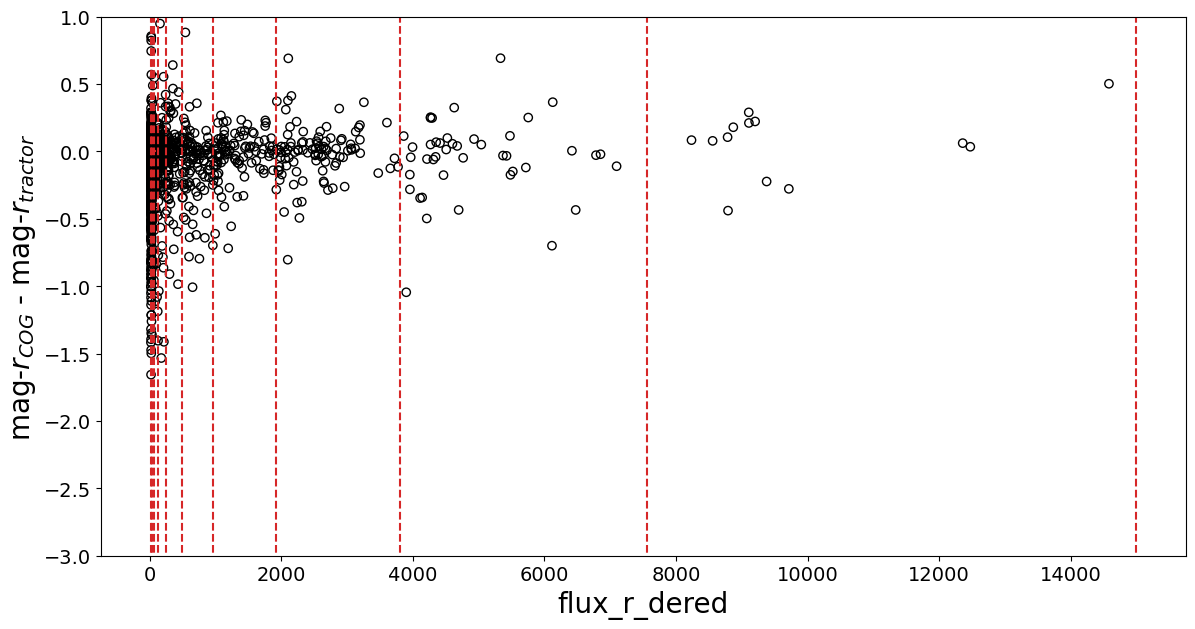

In [34]:
plt.figure(figsize=(14,7))

plt.scatter(r_flux, delta_mag_r, marker='o', lw=1, facecolor='none', edgecolor='k')
plt.hlines(0, 0, 100, ls='dashed', color='tab:red')
plt.xlabel('flux_r_dered', fontsize=20)
plt.ylabel(r'mag-$r_{COG}$ - mag-$r_{tractor}$', fontsize=20)
plt.vlines(flux_bins, -4, 4, ls='dashed', color='tab:red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-3,1)
# plt.close()

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

plot_data_and_sem(ax1, ax2, delta_mag_r_tractor, r_mag, mag_bins)

ax1.set_xlabel(r'mag-$r_{LP}$', fontsize=20)
ax1.set_xlim(11.5, 20)
ax2.set_xlabel(r'mag-$r_{LP}$', fontsize=20)
ax2.set_xlim(11.5, 20)

fig.tight_layout()
fig.savefig(figure_path+'1d_mag_residuals.png')
plt.close()

### Now looking at residuals as a function of redshift

In [36]:
col_min = min(z); col_max = max(z)
z_bins = np.linspace(col_min, col_max, 11).flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

plot_data_and_sem(ax1, ax2, delta_mag_r_tractor, z, z_bins)

ax1.set_xlabel(r'$z$', fontsize=20)
ax1.set_xlim(0, .6)
ax2.set_xlabel(r'$z$', fontsize=20)
ax2.set_xlim(0, .6)

fig.tight_layout()
fig.savefig(figure_path+'1d_z_residuals.png')
plt.close()

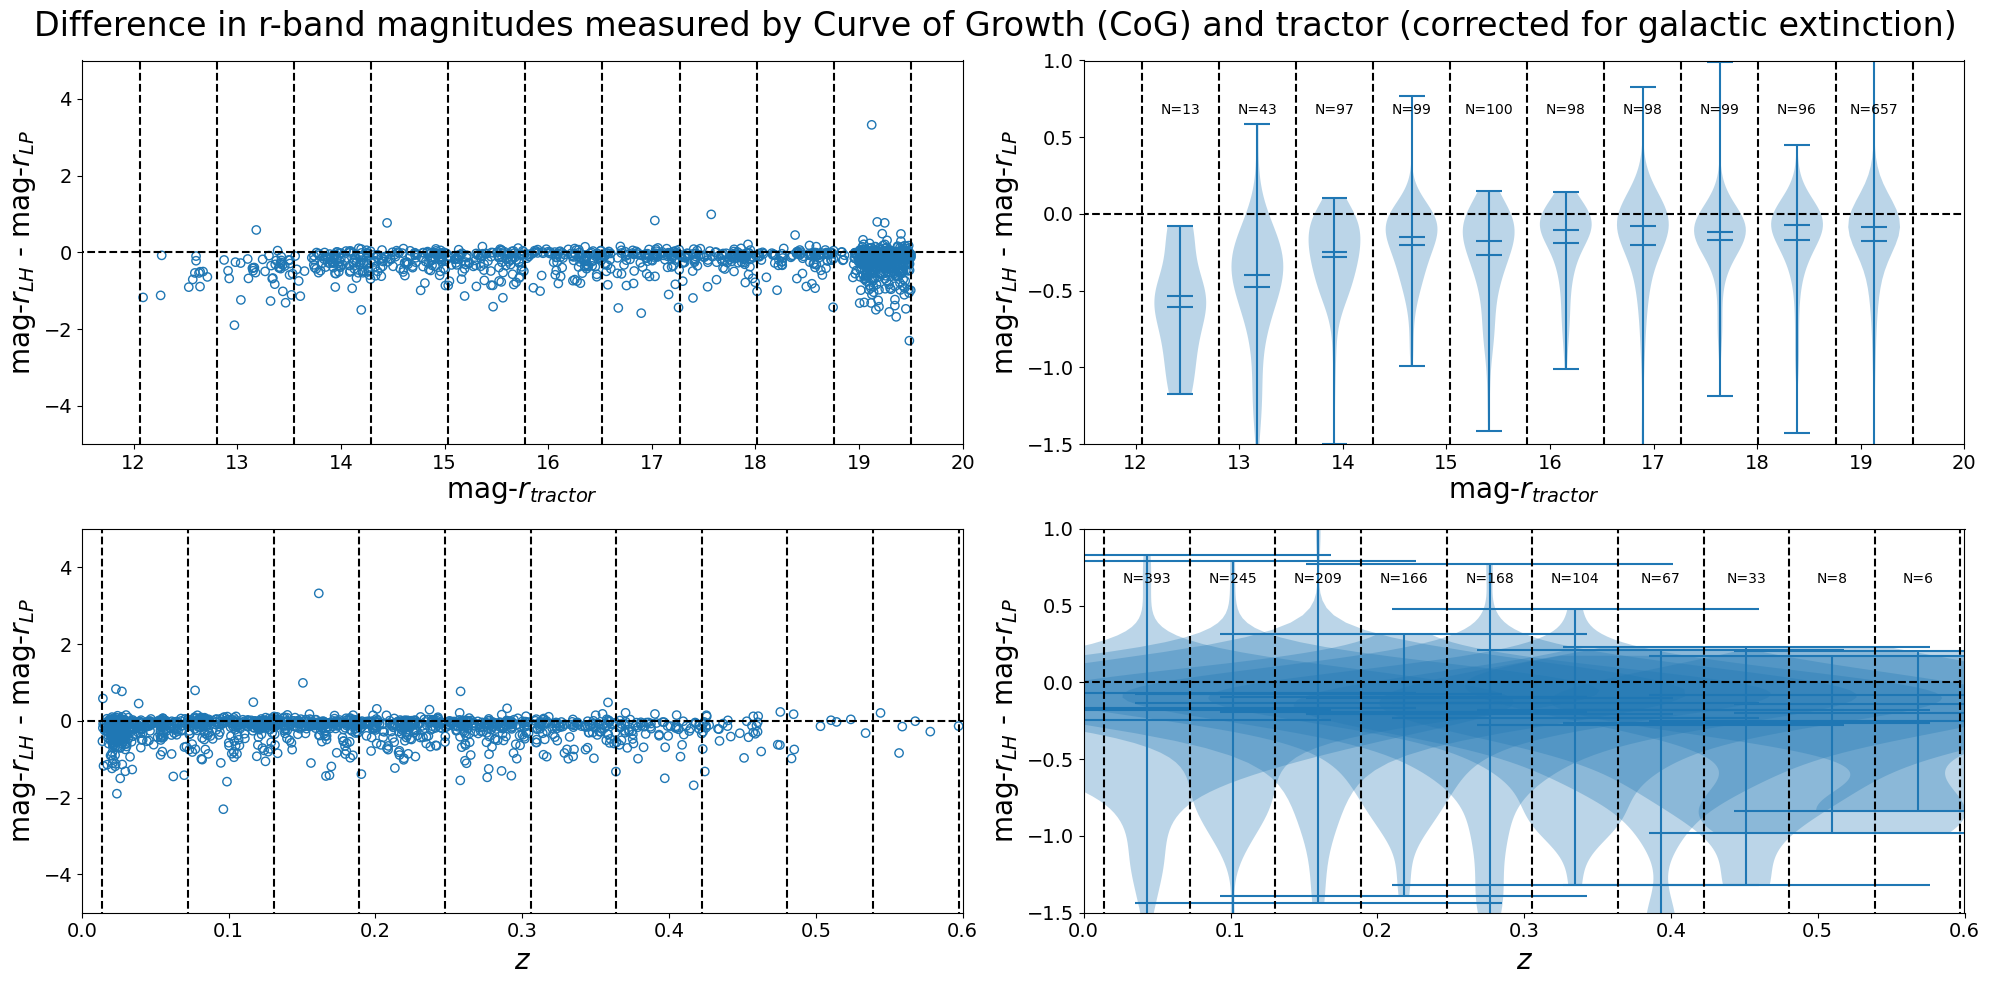

In [38]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('figure', facecolor='white')

fig, (row1, row2) = plt.subplots(2, 2, figsize=(20,10))

plot_data_and_sem(row1[0], row1[1], delta_mag_r_tractor, r_mag, mag_bins)
row1[0].set_xlabel(r'mag-$r_{tractor}$', fontsize=20)
row1[0].set_xlim(11.5, 20)
row1[1].set_xlabel(r'mag-$r_{tractor}$', fontsize=20)
row1[1].set_xlim(11.5, 20)


plot_data_and_sem(row2[0], row2[1], delta_mag_r_tractor, z, z_bins)
row2[0].set_xlabel(r'$z$', fontsize=20)
row2[0].set_xlim(0, .6)
row2[1].set_xlabel(r'$z$', fontsize=20)
row2[1].set_xlim(0, .6)


fig.suptitle('Difference in r-band magnitudes measured by Curve of Growth (CoG) and tractor (corrected for galactic extinction)', fontsize=24)
plt.tight_layout()
# plt.close()

In [19]:

for tc in tractor_columns:
    try:

        col_data = tractor[tc]
        col_min = min(col_data); col_max = max(col_data)
        
        if tc in log_scale_columns:
            col_bins = np.logspace(np.log10(col_min), np.log10(col_max), 11).flatten()
        else:
            col_bins = np.linspace(col_min, col_max, 11).flatten()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

        plot_data_and_sem(ax1, ax2, delta_mag_r_tractor, col_data, col_bins)

        ax1.set_xlabel(tc, fontsize=20)
        ax1.set_xlim(col_min, col_max)
        ax2.set_xlabel(tc, fontsize=20)
        ax2.set_xlim(col_min, col_max)
        if tc in log_scale_columns:
            ax2.set_xscale('log')
            ax1.set_xscale('log')

        fig.suptitle('Tractor Geometry', fontsize=24)
        fig.tight_layout()
        fig.savefig(figure_path+f'1d_tractor_{tc}_residuals.png')
        plt.close()
    except:
        print('Couldnt run residuals ', tc)
        invalid_cols.append(tc)
        plt.close()


/Users/matt/miniconda3/envs/legacyhalos/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matt/miniconda3/envs/legacyhalos/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/matt/miniconda3/envs/legacyhalos/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/matt/miniconda3/envs/legacyhalos/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/matt/miniconda3/envs/legacyhalos/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Couldnt run residuals  flux_r
Couldnt run residuals  flux_z
Couldnt run residuals  flux_ivar_r
Couldnt run residuals  rchisq_r


/var/folders/rn/gdlml1w17ds9ks621h70g9hw0000gn/T/ipykernel_8402/145123107.py:8: RuntimeWarning: invalid value encountered in log10
  col_bins = np.logspace(np.log10(col_min), np.log10(col_max), 11).flatten()
/var/folders/rn/gdlml1w17ds9ks621h70g9hw0000gn/T/ipykernel_8402/145123107.py:8: RuntimeWarning: divide by zero encountered in log10
  col_bins = np.logspace(np.log10(col_min), np.log10(col_max), 11).flatten()
/Users/matt/miniconda3/envs/legacyhalos/lib/python3.9/site-packages/numpy/core/function_base.py:157: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/matt/miniconda3/envs/legacyhalos/lib/python3.9/site-packages/numpy/core/function_base.py:167: RuntimeWarning: invalid value encountered in add
  y += start


Couldnt run residuals  fracflux_g
Couldnt run residuals  fracflux_r
Couldnt run residuals  fracflux_z
Couldnt run residuals  fracmasked_g
Couldnt run residuals  fracmasked_r
Couldnt run residuals  fracmasked_z
Couldnt run residuals  fracin_g
Couldnt run residuals  fracin_r
Couldnt run residuals  fracin_z
Couldnt run residuals  blob_nea_r
Couldnt run residuals  blob_nea_z
Couldnt run residuals  sersic_ivar
Couldnt run residuals  shape_e1_ivar
Couldnt run residuals  shape_e2_ivar


And derived columns of PA and e

In [20]:
tlbl = ['PA', 'e']
i = 0
for col_data in [pa, e]:
    col_min = min(col_data); col_max = max(col_data)
    col_bins = np.linspace(col_min, col_max, 11).flatten()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    plot_data_and_sem(ax1, ax2, delta_mag_r_tractor, col_data, col_bins)

    ax1.set_xlabel(tlbl[i], fontsize=20)
    ax1.set_xlim(col_min, col_max)
    ax2.set_xlabel(tlbl[i], fontsize=20)
    ax2.set_xlim(col_min, col_max)
    fig.suptitle('Tractor Geometry', fontsize=24)
    fig.tight_layout()
    fig.savefig(figure_path+f'1d_tractor_{tlbl[i]}_residuals.png')
    plt.close()
    i+=1

Now look at the ellipsefit parameter residuals

In [21]:
for ec in ellipse_cols:
    col_data = ellipse[ec.upper()]
    col_min = min(col_data); col_max = max(col_data)
    col_bins = np.linspace(col_min, col_max, 11).flatten()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    plot_data_and_sem(ax1, ax2, delta_mag_r_tractor, col_data, col_bins)

    ax1.set_xlabel(ec, fontsize=20)
    ax1.set_xlim(col_min, col_max)
    ax2.set_xlabel(ec, fontsize=20)
    ax2.set_xlim(col_min, col_max)
    fig.suptitle('Ellipse Fit Geometry', fontsize=24)
    fig.tight_layout()

    fig.savefig(figure_path+f'ellipse_fit_{ec}_residuals.png')
    plt.close()

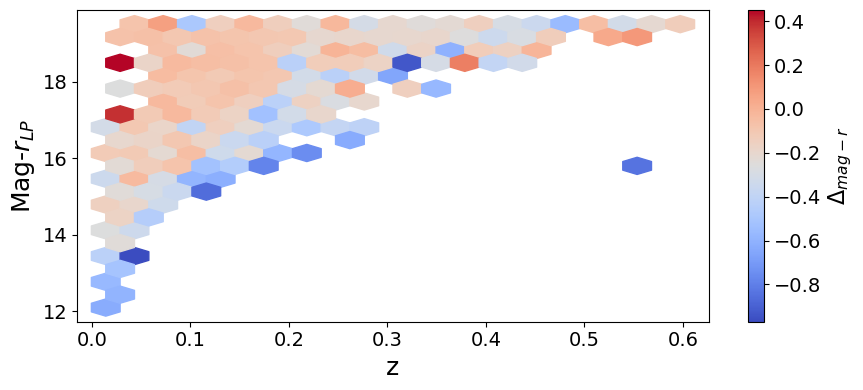

In [42]:
fig, (ax0) = plt.subplots(ncols=1, sharey=True, figsize=(9, 4))
hb = plt.hexbin(z, r_mag, C=delta_mag_r_tractor, gridsize=20, cmap='coolwarm')

cb = fig.colorbar(hb, ax=ax0)
cb.set_label(r'$\Delta_{mag-r}$', fontsize=16)
ax0.set_xlabel('z', fontsize=18)
ax0.set_ylabel('Mag-$r_{LP}$', fontsize=18)
fig.tight_layout()
# fig.savefig(figure_path+'2d_mag_z_residuals.png')
# plt.close()

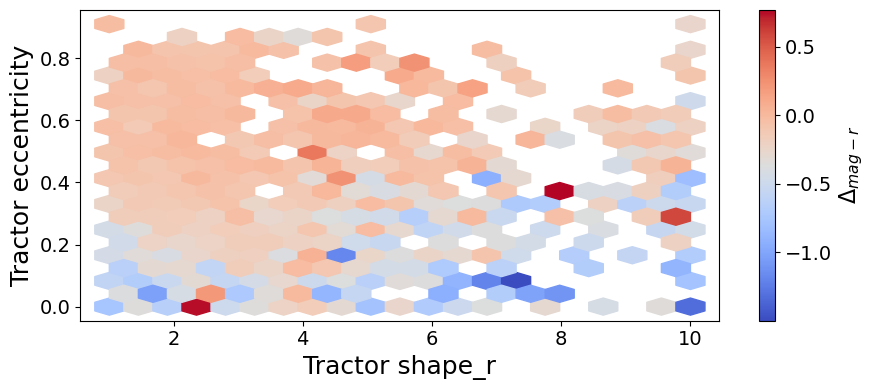

In [23]:
fig, (ax0) = plt.subplots(ncols=1, sharey=True, figsize=(9, 4))
hb = plt.hexbin(tractor['shape_r'], e, C=delta_mag_r_tractor, gridsize=20, cmap='coolwarm')

cb = fig.colorbar(hb, ax=ax0)
cb.set_label(r'$\Delta_{mag-r}$', fontsize=16)
ax0.set_xlabel('Tractor shape_r', fontsize=18)
ax0.set_ylabel('Tractor eccentricity', fontsize=18)
fig.tight_layout()
# fig.savefig(figure_path+'2d_tractor_shape_eccentricity_residuals.png')

# fig = plt.figure(figsize = (9,4))
# plt.close()


What seems to trend upwards / downwards?
* blob_nea_g:                   blob-masked noise equivalent area
* nea_g, nea_r, nea_z:          noise equivalent area
* rchisq_r, rchisq_z, rchisq_g  profle-weighted chi^2 of model fit 
* eccentricity                  
* shape_e2/1                    Ellipticity component 2/1 of galaxy model 
* shape_r (slightly)            Half-light radius of galaxy model for galaxy type
* low/high sersic               Power-law index for the Sersic profile model
* by, bx                        y, x, position of coordinates in brick image stack (0 index)



In [24]:
columns_of_interest = [
    'nea_r', 'rchisq_r', 'shape_e1', 'shape_e2', 'shape_r', 'sersic', 'eccentricity'
]

col_permutations = list(combinations(columns_of_interest, 2))


In [25]:
print(len(col_permutations))

21


In [26]:
for col1, col2 in col_permutations:
        
    fig, (ax0) = plt.subplots(ncols=1, sharey=True, figsize=(9, 4))

    if col1 == 'eccentricity':
        in1 = e
    else:
        in1 = tractor[col1]
    
    if col2 == 'eccentricity':
        in2 = e
    else:
        in2 = tractor[col2]
    
    x_scale = 'linear'
    y_scale = 'linear'
    if col1 in log_scale_columns:
        x_scale = 'log'
        ax0.set_xscale('log')
    if col2 in log_scale_columns:
        y_scale = 'log'
        ax0.set_yscale('log')

    hb = plt.hexbin(in1, in2, C=delta_mag_r_tractor, gridsize=20, cmap='coolwarm', xscale=x_scale, yscale=y_scale)

    cb = fig.colorbar(hb, ax=ax0)
    cb.set_label(r'$\Delta_{mag-r}$', fontsize=16)
    ax0.set_xlabel(f'Tractor {col1}', fontsize=18)
    ax0.set_ylabel(f'Tractor {col2}', fontsize=18)
    fig.tight_layout()
    fig.savefig(figure_path+f'2d_tractor_{col1}_{col2}_residuals.png')
    plt.close()


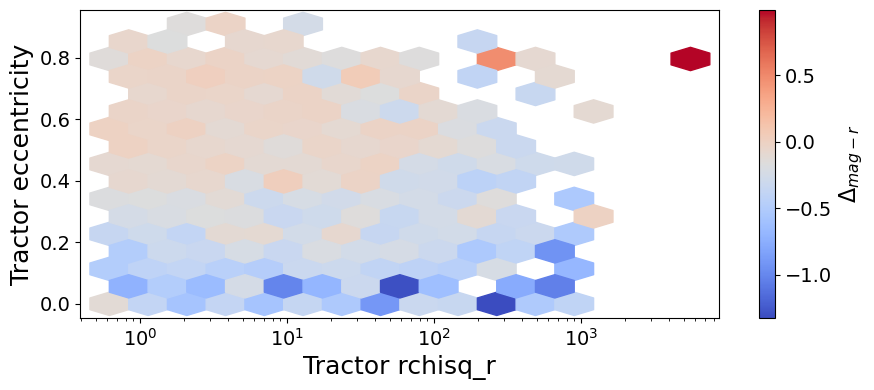

In [27]:
# nea_r, eccentricity

trac_col_x = 'rchisq_r'

fig, (ax0) = plt.subplots(ncols=1, sharey=True, figsize=(9, 4))
hb = plt.hexbin(tractor['rchisq_r'], e, C=delta_mag_r_tractor, xscale='log', gridsize=15, cmap='coolwarm')

cb = fig.colorbar(hb, ax=ax0)
cb.set_label(r'$\Delta_{mag-r}$', fontsize=16)
ax0.set_xlabel(f'Tractor {trac_col_x}', fontsize=18)
ax0.set_ylabel(f'Tractor eccentricity', fontsize=18)
fig.tight_layout()
# fig.savefig(figure_path+f'2d_tractor_eccentricity_{trac_col_x}_residuals.png')


Best 2D Residuals
* shape_r, eccentricity
* rchisq_r, eccentricity
* nea_r, eccentricity
* shape_e2/1, eccentricity
* shape_e2, shape_e1

Best 1D Residuals 
* eccentricity
* shape_r
* blob_nea_g
* nea_r
* rchisq_r
* bx, by